In [87]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,f1_score, roc_curve, auc,roc_auc_score
from imblearn.over_sampling import SMOTE
from MLSMOTE import get_tail_label,get_index,get_minority_instace,MLSMOTE

找出适合OneHotEncoder的数据

https://zhuanlan.zhihu.com/p/686452650

In [88]:
# 加载数据
X_train = np.load('../Training data/X_train.npy')  # 特征 (1000, 111)
y_train = np.load('../Training data/y_train.npy')  # 目标 (1000, 11)
x_test=np.load("../Testing data/X_test.npy")


x_train = pd.DataFrame(X_train).rename(columns={i: f"x_{i}" for i in range(111)})
y_train = pd.DataFrame(y_train).rename(columns={i: f"y_{i}" for i in range(11)})
x_test = pd.DataFrame(x_test).rename(columns={i: f"x_{i}" for i in range(111)})

#中位数填补
for column in x_train.columns:
    x_train.fillna({column: x_train[column].median()}, inplace=True)
    x_test.fillna({column: x_test[column].median()}, inplace=True)


# 找出非零值少于1%的列
threshold = 0.01  # 或者任何认为合适的值
cols_to_drop = [col for col in x_train.columns if (x_train[col] != 0).mean() < threshold]

# 删除这些列
x_train.drop(columns=cols_to_drop, inplace=True)
x_test.drop(columns=cols_to_drop, inplace=True)

# 特征缩放
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.fit_transform(x_test), columns=x_test.columns)


进行重采样

In [89]:
smote = SMOTE()
resampled_data = [];    max_size = 0
for i in range(y_train.shape[1]):
    x_resampled, y_resampled = smote.fit_resample(x_train, y_train.iloc[:, i])
    resampled_data.append((x_resampled, y_resampled))
    if len(y_resampled.values) > max_size:
        max_size = len(x_resampled)

In [90]:
# 使用SMOTE过采样处理不平衡的数据
X_train_smote, Y_train_smote = [], []

for x_resampled, y_resampled in resampled_data:
    smote = SMOTE(sampling_strategy={1: max_size - np.sum(y_resampled), 0: len(y_resampled) - np.sum(y_resampled)})
    x_resampled, y_resampled = smote.fit_resample(x_resampled, y_resampled)
    X_train_smote.append(x_resampled)
    Y_train_smote.append(y_resampled.values.reshape(-1, 1))


In [91]:
av_X_train_smote = np.array(X_train_smote[0])
for i in range(1, 11):
    av_X_train_smote += X_train_smote[i]
av_X_train_smote = av_X_train_smote / 11


In [92]:

X_train_smote = av_X_train_smote
Y_train_smote = np.hstack(Y_train_smote)


# 划分出来百分之二十的测试集
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train_smote, Y_train_smote, test_size=0.2, random_state=42)

# 将处理后的DataFrame转换回NumPy数组


NN部分

In [93]:
# 定义模型结构
shared_input = Input(shape=(X_train.shape[1], ), name='shared_input')
shared_layer = Dense(128, activation='sigmoid')(shared_input)
shared_layer = Dense(64, activation='relu')(shared_layer)
shared_layer = Dense(32, activation='relu')(shared_layer)

定义Specific部分

In [94]:
outputs = []
for i in range(11):
    task_output = Dense(16,  activation='sigmoid', name=f'task_{i}_hidden')(shared_layer)
    task_output = Dense(1,  activation='sigmoid', name=f'task_{i}_output')(task_output)
    outputs.append(task_output)
outputs = Concatenate(axis=-1)(outputs)

训练模型并输出

In [95]:
model = Model(inputs=shared_input, outputs=outputs)
# 编译模型，添加精确率和召回率指标
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', #将NN的值传入最终的separate models
    metrics=[
        tf.keras.metrics.Precision(name='precision', thresholds=[0.2, 0.5, 0.7, 0.8, 0.9, 0.95]),
        tf.keras.metrics.Recall(name='recall', thresholds=[0.2, 0.5, 0.7, 0.8, 0.9, 0.95]),
        tf.keras.metrics.CategoricalAccuracy(name='accuracy_score')
    ])


# 训练模型
history = model.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid))
# 计算模型在训练集上的精确率和召回率
train_precision = history.history['precision'] 
train_recall = history.history['recall']
train_accuracy = history.history['accuracy_score']

# 计算模型在验证集上的精确率和召回率
val_precision = history.history['val_precision']
val_recall = history.history['val_recall']
val_accuracy = history.history['val_accuracy_score']

# 打印训练集和验证集上的精确率和召回率
print(f'Train Precision: {train_precision[-1]}')
print(f'Train Recall: {train_recall[-1]}')
print(f'Train Accuracy: {train_accuracy[-1]}')
print(f'Validation Precision: {val_precision[-1]}')
print(f'Validation Recall: {val_recall[-1]}')
print(f'Validation Accuracy: {val_accuracy[-1]}')

Epoch 1/100


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy_score: 0.0196 - loss: 0.7391 - precision: 0.3544 - recall: 0.2806 - val_accuracy_score: 0.0444 - val_loss: 0.6901 - val_precision: 0.1735 - val_recall: 0.3324
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy_score: 0.0219 - loss: 0.6907 - precision: 0.1749 - recall: 0.3251 - val_accuracy_score: 0.0476 - val_loss: 0.6845 - val_precision: 0.1766 - val_recall: 0.3278
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy_score: 0.0244 - loss: 0.6768 - precision: 0.1857 - recall: 0.3237 - val_accuracy_score: 0.0444 - val_loss: 0.6703 - val_precision: 0.1837 - val_recall: 0.3170
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy_score: 0.0222 - loss: 0.6600 - precision: 0.1879 - recall: 0.3028 - val_accuracy_score: 0.0444 - val_loss: 0.6452 - val_precision: 0.1902 - val_recall: 0.3065
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy_score: 0.0158 - loss: 0.6223 - precision: 0.3040 - recall: 0.3089 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step
Average Accuracy: 0.36507936507936506
Macro F1 Score: 0.7713228547781331
Micro F1 Score: 0.7703160270880361
              precision    recall  f1-score   support

         y_0       0.79      0.79      0.79       159
         y_1       0.79      0.80      0.79       147
         y_2       0.70      0.77      0.73       155
         y_3       0.78      0.83      0.80       145
         y_4       0.83      0.77      0.80       161
         y_5       0.76      0.75      0.76       162
         y_6       0.83      0.72      0.77       159
         y_7       0.82      0.71      0.76       165
         y_8       0.81      0.69      0.74       206
         y_9       0.79      0.77      0.78       167
        y_10       0.74      0.78      0.76       174

   micro avg       0.78      0.76      0.77      1800
   macro avg       0.78      0.76      0.77      1800
weighted avg       0.79      0.76      0.77      1800
 samples avg       0.49      0.51      

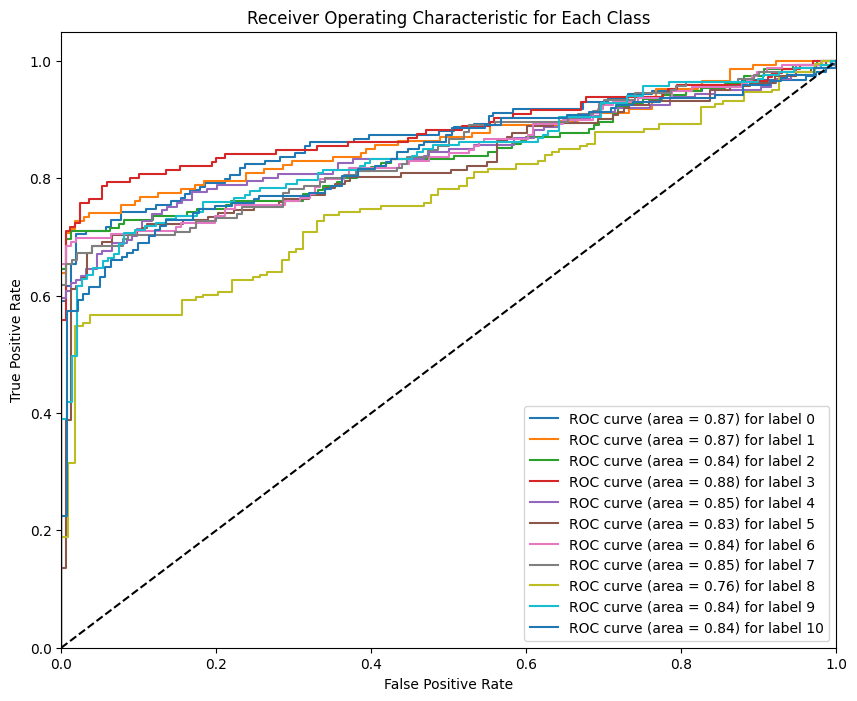

Micro-average AUC: 0.8390540540540541
Macro-average AUC: 0.8431255434325304


In [97]:
# 使用模型进行预测
Y_pred = model.predict(X_valid)

# 阈值处理，这里我们将0.5作为分类阈值
Y_pred_binary = (Y_pred > 0.5).astype(int)

# 计算平均精度
average_accuracy = accuracy_score(Y_valid, Y_pred_binary)
print("Average Accuracy:", average_accuracy)

# 计算宏观F1和微观F1
macro_f1 = f1_score(Y_valid, Y_pred_binary, average='macro')
micro_f1 = f1_score(Y_valid, Y_pred_binary, average='micro')
print("Macro F1 Score:", macro_f1)
print("Micro F1 Score:", micro_f1)

# 生成分类报告
report = classification_report(Y_valid, Y_pred_binary, target_names=[f'y_{i}' for i in range(Y_valid.shape[1])], zero_division=0)
print(report)

# 打印训练集和验证集上的最后一个epoch的精确率和召回率
print(f'Train Precision: {train_precision[-1]}')
print(f'Train Recall: {train_recall[-1]}')
print(f'Validation Precision: {val_precision[-1]}')
print(f'Validation Recall: {val_recall[-1]}')


# 使用模型进行预测获取概率输出
Y_pred_proba = model.predict(X_valid)

# 为每个类别绘制ROC曲线和计算AUC
plt.figure(figsize=(10, 8))
for i in range(Y_valid.shape[1]):
    fpr, tpr, _ = roc_curve(Y_valid[:, i], Y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for label {i}')

plt.plot([0, 1], [0, 1], 'k--')  # 绘制对角线
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc="lower right")
plt.show()

# 计算总的微观和宏观平均AUC
micro_auc = roc_auc_score(Y_valid, Y_pred_proba, average="micro")
macro_auc = roc_auc_score(Y_valid, Y_pred_proba, average="macro")
print("Micro-average AUC:", micro_auc)
print("Macro-average AUC:", macro_auc)